In [1]:
# Author: Lee Yat Shun, Jasper
# Copyright (c) 2023 Lee Yat Shun, Jasper. All rights reserved.

In [2]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from caviar import CaviarModel
from backtesting import backtest
from var_tests import binomial_test, kupiec_pof_test, christoffersen_test

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_excel('../data/SPY.xlsx')
df.columns = df.iloc[5].values
df = df.iloc[6:].iloc[::-1].reset_index(drop=True)
df['Log Return'] = df.PX_LAST.apply(lambda x: np.log(x)).diff()
df = df.set_index('Date')
df.head()

,PX_LAST,Change,% Change,PX_OPEN,Change,% Change,PX_HIGH,Change,% Change,PX_LOW,Change,% Change,Log Return
Date,,,,,,,,,,,,,
1993-01-29,25.2238,NaN,NaN,25.2417,NaN,NaN,25.2417,NaN,NaN,25.1161,NaN,NaN,NaN
1993-02-01,25.4032,NaN,NaN,25.2417,NaN,NaN,25.4032,NaN,NaN,25.2417,NaN,NaN,0.007087
1993-02-02,25.457,NaN,NaN,25.3852,NaN,NaN,25.4749,NaN,NaN,25.3314,NaN,NaN,0.002116
1993-02-03,25.7261,NaN,NaN,25.4929,NaN,NaN,25.744,NaN,NaN,25.4749,NaN,NaN,0.010515
1993-02-04,25.8337,NaN,NaN,25.8158,NaN,NaN,25.8876,NaN,NaN,25.762,NaN,NaN,0.004174


In [5]:
returns = df['Log Return'].dropna()
low_open_log_difference = (df['PX_LOW'].apply(lambda x: np.log(x)) - df['PX_OPEN'].apply(lambda x: np.log(x))).dropna()

## Numeric

In [6]:
in_samples = returns[2000:-2000] * 100
out_of_samples = returns[-2000:] * 100

In [7]:
# initiate parameter
quantile = 0.05 # 5% VAR

In [48]:
# instantiation
caviar_model = CaviarModel(quantile, model='symmetric', method='mle')
caviar_model

CaviarModel(quantile=0.05, model=symmetric, method=mle, G=10, tol=1e-10, LAGS=4)

In [49]:
caviar_model.fit(in_samples)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -3773.4365880660284
        x: [ 1.276e-01 -3.029e-02  9.006e-01 -1.928e-01]
      nit: 27
      jac: [ 8.568e+01  6.877e+01  1.534e+02  1.055e+02]
     nfev: 510
     njev: 102
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
Final loss: 0.1272006158872287
Time taken(s): 4.36


In [50]:
print('S.E. of beta:', caviar_model.beta_standard_errors)
print('pval of beta:', caviar_model.beta_pvals)

S.E. of beta: [0.02148783 0.04353412 0.0768085 ]
pval of beta: [7.92983730e-02 2.20785020e-95 6.02863596e-03]


### Backtesting on the out of samples

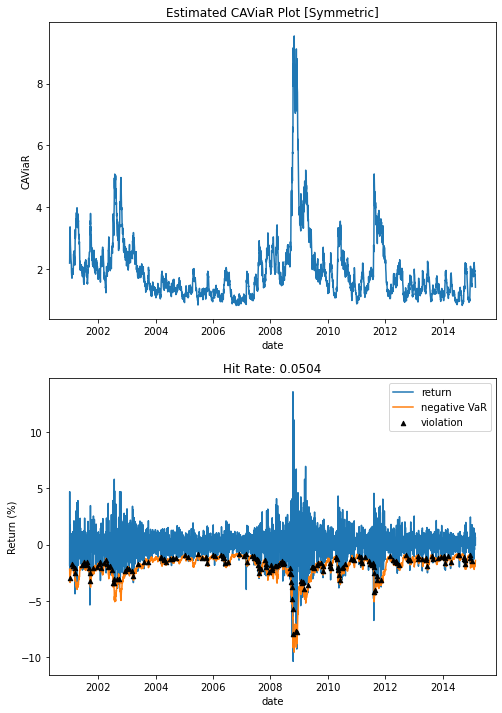

In [51]:
# in sample
caviar_model.plot_caviar(in_samples, 'in')

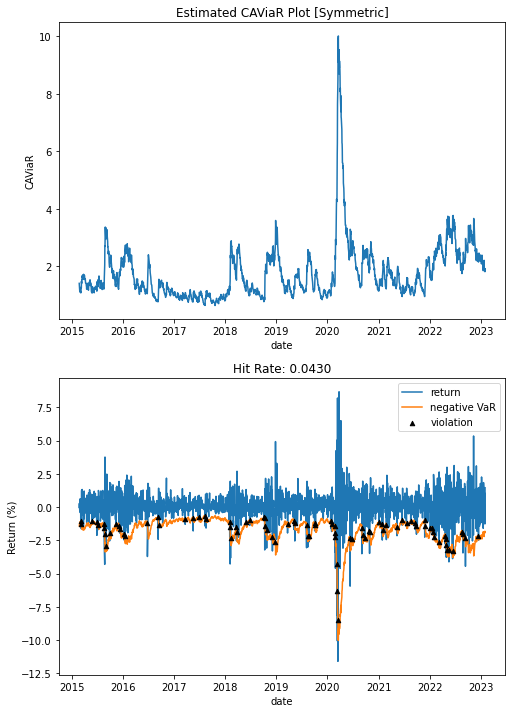

In [52]:
# out of sample
caviar_model.plot_caviar(out_of_samples, 'out')

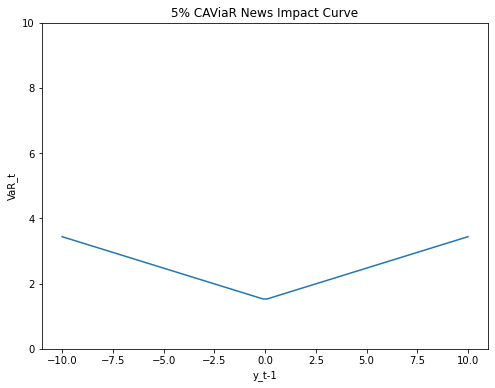

In [53]:
caviar_model.plot_news_impact_curve(VaR=-1.645)

### VaR Test

In [54]:
in_VaR = caviar_model.predict(in_samples, caviar_model.VaR0_in)

In [55]:
out_VaR = caviar_model.predict(out_of_samples, caviar_model.VaR0_out)

In [56]:
(out_of_samples[1:] < out_VaR[:-1]).value_counts(normalize=True)

False    0.956978
True     0.043022
Name: Log Return, dtype: float64

In [57]:
# The null hypothesis states that the current VaR violations are uncorrelated with past violations.

print(caviar_model.dq_test(in_samples, 'in'))
print(caviar_model.dq_test(out_of_samples, 'out'))

0.22332085928802994
0.9897878916915841


In [58]:
# H0: the obs ~ binomial(p)

print(binomial_test(in_samples, in_VaR, caviar_model.quantile))
print(binomial_test(out_of_samples, out_VaR, caviar_model.quantile))

0.908093164688173
0.16567523420130487


In [59]:
# H0: the observed failure rate is equal to the failure rate suggested by the confidence interval.

print(kupiec_pof_test(in_samples, in_VaR, caviar_model.quantile))
print(kupiec_pof_test(out_of_samples, out_VaR, caviar_model.quantile))

1.0
1.0


In [60]:
# null hypothesis: the observations are independent of each other

print(christoffersen_test(in_samples, in_VaR))
print(christoffersen_test(out_of_samples, out_VaR))

0.004331556705439644
0.8931747964383598


### Mean reversion property?

In [61]:
# the_following_day = out_of_samples[1:][out_of_samples[1:] < out_VaR[:-1]].index + pd.Timedelta(1, unit='D')

# equivalently
the_following_day = np.array(range(1999))[out_of_samples[1:] < out_VaR[:-1]] + 1

In [62]:
out_of_samples[1:].iloc[the_following_day].describe()

count    86.000000
mean      0.353832
std       1.897368
min      -4.301879
25%      -0.407907
50%       0.249436
75%       1.167786
max       8.202780
Name: Log Return, dtype: float64

In [63]:
(out_of_samples[1:].iloc[the_following_day]/100 + 1).cumprod()

Date
2015-03-09    1.004136
2015-03-11    1.001783
2015-06-30    1.003878
2015-07-09    1.005692
2015-08-21    0.974953
                ...   
2022-06-14    1.357886
2022-08-23    1.354596
2022-08-29    1.345609
2022-09-14    1.350735
2022-12-16    1.334694
Name: Log Return, Length: 86, dtype: float64

<AxesSubplot:ylabel='Frequency'>

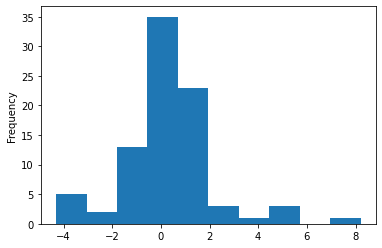

In [64]:
out_of_samples[1:].iloc[the_following_day].plot.hist()

### Backtesting

In [65]:
out_low_open_log_difference = low_open_log_difference.loc[out_of_samples.index]
(out_low_open_log_difference * 100 < out_VaR).value_counts(normalize=True)

False    0.944
True     0.056
dtype: float64

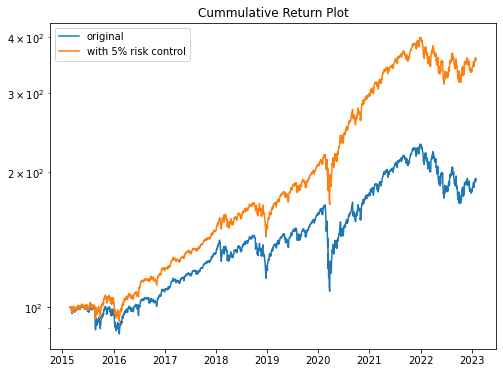

In [66]:
# with 0.2% transaction cost

backtest(out_of_samples, out_low_open_log_difference, out_VaR, caviar_model.quantile, ntl=100, penalty=0.002)

### Forecast

In [67]:
caviar_model.forecast(out_of_samples[-1], out_VaR[-1])

-2.0291380784490496